In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import obonet
import random
import torch
import math
from Bio import SeqIO
import Bio.PDB
import urllib.request
import py3Dmol
import pylab
import pickle as pickle
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import GENConv
from torch_geometric.nn.models import MLP
from torch_geometric.data import Data
from torch_geometric.nn.pool import SAGPooling
from torch_geometric.nn.aggr import MeanAggregation
import matplotlib.pyplot as plt
import os
from Bio import PDB
from rdkit import Chem

In [2]:
class CFG:
    pdbfiles: str = "/home/paul/BioHack/pdbind-refined-set/"

In [17]:
def remove_hetatm(input_pdb_file, output_pdb_file):
    # Open the input PDB file for reading and the output PDB file for writing
    with open(input_pdb_file, 'r') as infile, open(output_pdb_file, 'w') as outfile:
        for line in infile:
            # Check if the line starts with 'HETATM' (non-protein atoms)
            if line.startswith('HETATM'):
                continue  # Skip this line (HETATM record)
            # Write all other lines to the output file
            outfile.write(line)
            
def get_atom_types_from_sdf(sdf_file):
    supplier = Chem.SDMolSupplier(sdf_file)
    atom_types = set()

    for mol in supplier:
        if mol is not None:
            atoms = mol.GetAtoms()
            atom_types.update([atom.GetSymbol() for atom in atoms])

    return sorted(list(atom_types))

In [4]:
def one_hot_encode(seq):
    allowed = set("GAVCPLIMWFKRHSTYNQDE")
    if not set(seq).issubset(allowed):
        invalid = set(seq) - allowed
        raise ValueError(f"Sequence has broken AA: {invalid}")
        
    AA_dict = {'G':torch.Tensor([1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'A':torch.Tensor([0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'V':torch.Tensor([0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'C':torch.Tensor([0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'P':torch.Tensor([0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'L':torch.Tensor([0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'I':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'M':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'W':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'F':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'K':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'R':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'H':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'S':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'T':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0]),
               'Y':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0]),
               'N':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0]),
               'Q':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0]),
               'D':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]),
               'E':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]),}
        
    vec=np.array([AA_dict[x] for x in seq])
    return vec

def one_hot_encode_single_res(res):
    allowed = set("GAVCPLIMWFKRHSTYNQDEUO")
    if not set(res).issubset(allowed):
        invalid = set(res) - allowed
        raise ValueError(f"Sequence has broken AA: {invalid}")
        
    AA_dict = {'GLY':torch.Tensor([1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'ALA':torch.Tensor([0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'VAL':torch.Tensor([0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'CYS':torch.Tensor([0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'PRO':torch.Tensor([0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'LEU':torch.Tensor([0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'ILE':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'MET':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'TRP':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'PHE':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'LYS':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'ARG':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'HIS':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'SER':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0]),
               'THR':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0]),
               'TYR':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0]),
               'ASN':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0]),
               'GLN':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0]),
               'ASP':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0]),
               'GLU':torch.Tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]),}
    return AA_dict[res]

def calc_residue_dist(residue_one, residue_two) :
    """Returns the C-alpha distance between two residues"""
    diff_vector  = residue_one["CA"].coord - residue_two["CA"].coord
    return np.sqrt(np.sum(diff_vector * diff_vector))

def calc_dist_matrix(chain_one, chain_two) :
    """Returns a matrix of C-alpha distances between two chains"""
    answer = np.zeros((len(chain_one), len(chain_two)), float)
    for row, residue_one in enumerate(chain_one) :
        for col, residue_two in enumerate(chain_two) :
            answer[row, col] = calc_residue_dist(residue_one, residue_two)
    return answer

def calc_contact_map(uniID,map_distance):
    pdb_code = uniID
    pdb_filename = uniID+".pdb"
    structure = Bio.PDB.PDBParser().get_structure(pdb_code, (CFG.alphafold_strucures +'/'+pdb_filename))
    model = structure[0]
    pLDDT_vec = []
    for atom in structure.get_atoms():
        if atom.name == "CA":
            pLDDT_vec.append(atom.bfactor)
    dist_matrix = calc_dist_matrix(model["A"], model["A"])
    contact_map = dist_matrix < map_distance
    return contact_map, pLDDT_vec

def map2graph(contact_map,pLDDT):
    size = np.shape(contact_map)
    D = np.zeros(size[0])
    A = []
    edge_attr=[]
    for j in range(size[0]):
        D[j] = sum(contact_map[j])
        for i in range(j):
            if contact_map[j][i] == 1:
                A.append([int(j),int(i)])
                edge_attr.append((pLDDT[i]+pLDDT[j])/200.0)
    A = np.array(A)
    A = A.transpose()
    D = torch.Tensor(D)
    D = torch.unsqueeze(D,1)
    edge_attr = torch.Tensor(edge_attr)
    edge_attr = torch.unsqueeze(edge_attr,1)
    A = torch.Tensor(A)
    A = A.to(torch.int64)
    graph = Data(x = D, edge_index = A,edge_attr = edge_attr)
    return graph

def uniID2graph(uniID,map_distance):
    atom_names = ['N','CA','C','CB','O']
    atom_names_gly = ['N','CA','C','CA','O']
    node_feature = []
    edge_index = []
    edge_attr = []
    contact_map, pLDDT = calc_contact_map(uniID,map_distance)
    size = np.shape(contact_map)
    pdb_code = uniID
    pdb_filename = uniID+".pdb"
    structure = Bio.PDB.PDBParser().get_structure(pdb_code, (CFG.alphafold_strucures +'/'+pdb_filename))
    model = structure[0]

    for chain in model:
        for i in range(size[0]):
            node_feature.append(one_hot_encode_single_res(chain[i+1].get_resname()))
            for j in range(i):
                if contact_map[i,j] == 1:
                    weight = (pLDDT[i]+pLDDT[j])/200.0
                    edge_index.append([i,j])
                    edge_feature = []
                    if chain[i+1].get_resname() == 'GLY' or chain[j+1].get_resname() == 'GLY':
                        if chain[i+1].get_resname() == 'GLY' and chain[j+1].get_resname() == 'GLY':
                            for atom1 in atom_names_gly:
                                for atom2 in atom_names_gly:
                                    diff_vector  = chain[i+1][atom1].coord - chain[j+1][atom2].coord
                                    edge_feature.append((np.sqrt(np.sum(diff_vector * diff_vector))/map_distance)*weight)
                        elif chain[i+1].get_resname() == 'GLY' and chain[j+1].get_resname() != 'GLY':
                            for atom1 in atom_names_gly:
                                for atom2 in atom_names:
                                    diff_vector  = chain[i+1][atom1].coord - chain[j+1][atom2].coord
                                    edge_feature.append((np.sqrt(np.sum(diff_vector * diff_vector))/map_distance)*weight)
                        elif chain[i+1].get_resname() != 'GLY' and chain[j+1].get_resname() == 'GLY':
                            for atom1 in atom_names:
                                for atom2 in atom_names_gly:
                                    diff_vector  = chain[i+1][atom1].coord - chain[j+1][atom2].coord
                                    edge_feature.append((np.sqrt(np.sum(diff_vector * diff_vector))/map_distance)*weight)                                
                    else:
                        for atom1 in atom_names:
                            for atom2 in atom_names:
                                diff_vector  = chain[i+1][atom1].coord - chain[j+1][atom2].coord
                                edge_feature.append((np.sqrt(np.sum(diff_vector * diff_vector))/map_distance)*weight)
                    edge_attr.append(edge_feature)

    edge_index = np.array(edge_index)
    edge_index = edge_index.transpose()
    edge_index = torch.Tensor(edge_index)
    edge_index = edge_index.to(torch.int64)
    edge_attr = torch.Tensor(edge_attr)
    node_feature = torch.stack(node_feature)
    graph = Data(x = node_feature, edge_index = edge_index,edge_attr = edge_attr)
    return graph

In [5]:
total_count = 0
file_count = 0
for filename in os.listdir(CFG.pdbfiles):
    num_files = 0
    for file in os.listdir(CFG.pdbfiles+filename):
        num_files += 1
    if num_files > 0:
        file_count += 1
    total_count += 1

print(total_count)
print(file_count)

5316
5316


In [32]:
for filename in os.listdir(CFG.pdbfiles):
    input_pdb_filename = CFG.pdbfiles+filename+'/'+filename+'_pocket'
    output_pdb_filename = input_pdb_filename+'_clean.pdb'
    remove_hetatm(input_pdb_filename+'.pdb', output_pdb_filename)


In [18]:
Atom_type_count = {}
for filename in os.listdir(CFG.pdbfiles):
    sdf_file = CFG.pdbfiles+filename+'/'+filename+'_ligand.sdf'
    atoms = get_atom_types_from_sdf(sdf_file)
    for atom in atoms:
        if atom in Atom_type_count:
            Atom_type_count[atom] += 1
        else:
            Atom_type_count.update({atom: 1})

[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:18] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
[19:50:18] ERROR: Could not sanitize molecule ending on line 110
[19:50:18] ERROR: Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
[19:50:18] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the

[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Can't kekulize mol.  Unkekulized atoms: 6 26 27 28 29 30 31 32 33
[19:50:19] ERROR: Could not sanitize molecule ending on line 123
[19:50:19] ERROR: Can't kekulize mol.  Unkekulized atoms: 6 26 27 28 29 30 31 32 33
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the m

[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 17 21 22
[19:50:19] ERROR: Could not sanitize molecule ending on line 110
[19:50:19] ERROR: Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 17 21 22
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Can't kekulize mol.  Unkekulized atoms: 1 2 15 20 21
[19:50:19] ERROR: Could not sanitize molecule en

[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:19] Can't kekulize mol.  Unkekulized atoms: 3 4 20 21 22
[19:50:19] ERROR: Could not sanitize molecule ending on line 84
[19:50:19] ERROR: Can't kekulize mol.  Unkekulized atoms: 3 4 20 21 22
[19:50:19] Warnin

[19:50:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:20] Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8 9 10 11
[19:50:20] ERROR: Could not sanitize molecule ending on line 60
[19:50:20] ERROR: Can't kekulize mol.  Unkekulized atoms: 2 4 5 6 7 8 9 10 11
[19:50:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[19:50:20] Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 22 23 24
[19:50:20] ERROR: Could not sanitize molecule ending on line 115
[19:50:20] ERROR: Can't kekulize mol.  Unkekulized atoms: 15 16 17 18 19 20 22 23 24
[19:50:20] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.

In [20]:
x = []
count = []
for atom in Atom_type_count:
    x.append(atom)
    count.append(Atom_type_count[atom])

In [5]:
with open(CFG.CC_Codes) as f:
    lines = f.readlines()
CC_Codes = list(lines)
for i in range(len(CC_Codes)):
    CC_Codes[i] = CC_Codes[i][0:10]

In [6]:
GO_code_graph = obonet.read_obo(CFG.train_go_obo_path)

In [7]:
def graph2dict(graph,codes):
    count = 0
    out_id = {}
    for i in graph:
        if i in codes:
            x = np.zeros(len(codes))
            x[count] = 1.
            count +=1
            out_id.update({str(i): x})
    return out_id

In [8]:
out_id = graph2dict(GO_code_graph,CC_Codes)
len(out_id)

4043

In [9]:
#sequences = list(SeqIO.parse(CFG.train_seq_fasta_path, "fasta"))
#train_terms_df = pd.read_csv(CFG.train_terms_path, sep="\t")
#prot_list =[]
#count = 0
#for entry in sequences:
#    UniID = entry.description[0:6]
#    if UniID in UniIDs:
#        terms_list = train_terms_df.loc[train_terms_df["EntryID"]==UniID]
#        function_vec = np.zeros(len(CC_Codes))
#        for term in terms_list.term:
#            if str(term) in out_id:
#                function_vec += out_id[str(term)]
#        graph = uniID2graph(UniID,12.0)
#        prot_list.append([graph,torch.tensor(function_vec)])
#        count += 1
#    if count%2000 == 0:
#        print(count)

In [10]:
graphs = torch.load('graph_for_GATConv_BLOSUM_ENCODING_master_node_clean.pt')
encode = torch.load('encode_10142023.pt')

In [11]:
graph = random.choice(graphs)

In [12]:
print(len(encode))
print(len(graphs))

57272
57272


In [13]:
prot_list = []
for i in range(len(graphs)):
    prot_list.append([graphs[i],encode[i].squeeze()])


In [14]:
dataset = []
for i in prot_list:
    i[0].y = i[1]
    dataset.append(i)

In [15]:
del graphs
del encode
del prot_list

In [63]:
a = torch.rand(4)
b = torch.rand(4)

a+b

torch.cat(a)

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [16]:
#func_real = np.zeros(len(CC_Codes))
#for prot in prot_list:
#    func_real += prot[1].numpy()
#    
#weights = np.zeros(len(CC_Codes))
#for i in range(len(CC_Codes)):
#    positive = func_real[i]
#    negative = len(prot_list) - func_real[i]
#    if positive < 100:
#        weights[i] = 0
#    else:
#        weights[i] = negative/positive #15.0*math.tanh(negative/positive)
#        
#weights = torch.tensor(weights)

In [17]:
#plt.hist(weights, bins = 1000)
#plt.yscale('log')
#plt.show()

In [18]:
# GCN model with 2 layers 
#class Net(torch.nn.Module):
#    def __init__(self):
#        super(Net, self).__init__()
#        self.conv1 = GATConv(20,20,heads = 1,concat = False)
#        self.conv2 = GATConv(20,20,heads = 1,concat = False)
#        self.conv3 = GATConv(20,20,heads = 1,concat = False)
#        self.ReLu = nn.ReLU()
#        self.linear1 = nn.Linear(960,960)
#        self.linear2 = nn.Linear(960,1920)
#        self.linear3 = nn.Linear(1920,4043)
#        self.sigmoid = nn.Sigmoid()
#
#    def forward(self,graph):
#        x, edge_index, edge_attr = graph.x,graph.edge_index,graph.edge_attr
#        x1 = self.conv1(x, edge_index,edge_attr)
#        x1_relu = self.ReLu(x1)
#        x1_relu = F.dropout(x1_relu, p= 0.3, training=True)
#        x2 = self.conv2(x1_relu, edge_index,edge_attr)
#        x2_relu = self.ReLu(x2)
#        x2_relu = F.dropout(x2_relu, p= 0.3, training=True)
#        x3 = self.conv3(x2_relu, edge_index,edge_attr)
#        x3_relu = self.ReLu(x3)
#        x3_relu = F.dropout(x3_relu, p= 0.3, training=True)
#        flat_x1 = torch.flatten(x1)
#        flat_x2 = torch.flatten(x2)
#        flat_x3 = torch.flatten(x3)
#        x_cat = torch.cat((flat_x1,flat_x2,flat_x3),0)
#        admaxpool = nn.AdaptiveMaxPool1d(960)
#        in_layer = admaxpool(x_cat.unsqueeze(0)).squeeze()
#        hidden_layer1 = self.linear1(in_layer)
#        hidden_layer2 = self.linear2(hidden_layer1)
#        out_layer = self.linear3(hidden_layer2)
#        out_layer = self.sigmoid(out_layer)
#        return out_layer

Smaller Model

In [19]:
#class Net(torch.nn.Module):
#    def __init__(self):
#        super(Net, self).__init__()
#        self.nodes = 100
#        self.node_feature_size = 20
#        self.dropout = 0.6
#        self.conv1 = GENConv(20,20,aggr = 'mean',edge_dim = 9)
#        self.conv2 = GATv2Conv(self.node_feature_size,5, edge_dim = 9, heads = 4,concat = True, dropout = self.dropout)
#        self.conv3 = GENConv(20,20,aggr = 'mean',edge_dim = 9)
#        self.SAGpool1 = SAGPooling(self.node_feature_size,self.nodes,GNN = GCNConv)
#        self.SAGpool2 = SAGPooling(self.node_feature_size,self.nodes,GNN = GCNConv)
#        self.SAGpool3 = SAGPooling(self.node_feature_size,self.nodes,GNN = GCNConv)
#        self.dropout = nn.Dropout(p = 0.3)
#        self.ReLu = nn.ReLU()
#        self.linear1 = nn.Linear(self.nodes*self.node_feature_size*3,1024)
#        self.linear2 = nn.Linear(1024,512)
#        self.linear3 = nn.Linear(512,len(prot_list[0][1]))
#
#    def forward(self,graph):
#        x, edge_index, edge_attr = graph.x,graph.edge_index,graph.edge_attr
#        x1 = self.conv1(x, edge_index,edge_attr)
#        x1 = self.ReLu(x1)
#        pool1 = self.SAGpool1(x1, edge_index,edge_attr)
#        x2 = self.conv2(x1, edge_index,edge_attr)
#        x2 = self.ReLu(x2)
#        pool2 = self.SAGpool2(x2, edge_index,edge_attr)
#        x3 = self.conv3(x2, edge_index,edge_attr)
#        x3 = self.ReLu(x3)
#        pool3 = self.SAGpool3(x3, edge_index,edge_attr)
#        x1 = torch.flatten(pool1[0])
#        x2 = torch.flatten(pool2[0])
#        x3 = torch.flatten(pool3[0])
#        if x1.size()[0] < (self.nodes*self.node_feature_size):
#            x1 = torch.nn.functional.pad(x1,(0,(self.nodes*self.node_feature_size - x1.size()[0])))
#            x2 = torch.nn.functional.pad(x2,(0,(self.nodes*self.node_feature_size - x2.size()[0])))
#            x3 = torch.nn.functional.pad(x3,(0,(self.nodes*self.node_feature_size - x3.size()[0])))
#        x1 = torch.cat((x1,x2,x3),0)
#        x1 = self.dropout(x1)
#        x1 = self.linear1(x1)
#        x1 = self.dropout(x1)
#        x1 = self.ReLu(x1)
#        x1 = self.linear2(x1)
#        x1 = self.ReLu(x1)
#        x1 = self.linear3(x1)
#        return x1

In [57]:
graph = random.choice(dataset)
x = graph[0].x
master_nodes = []
for i in range(x.size()[0]):
    mask = torch.eq(x[i], 0)
    count = mask.sum().item()
    if count == 20:
        master_nodes.append(i)

In [58]:
print(x[master_nodes[0]])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [153]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.nodes = 50
        self.node_feature_size = 20
        self.node_feature_hidden_size = 120
        self.dropout = 0.3
        self.conv1 = GENConv(self.node_feature_size,self.node_feature_hidden_size,aggr = 'mean',edge_dim = 9,num_layer = 3)
        self.conv2 = GATv2Conv(self.node_feature_hidden_size,10, edge_dim = 9, heads = 12,concat = True, dropout = self.dropout)
        self.conv3 = GENConv(self.node_feature_hidden_size,self.node_feature_hidden_size,aggr = 'mean',edge_dim = 9,num_layer = 3)
        self.conv4 = GATv2Conv(self.node_feature_hidden_size,10, edge_dim = 9, heads = 12,concat = True, dropout = self.dropout)
        self.conv5 = GENConv(self.node_feature_hidden_size,self.node_feature_hidden_size,aggr = 'mean',edge_dim = 9,num_layer = 3)
        self.conv6 = GATv2Conv(self.node_feature_hidden_size,self.node_feature_hidden_size, edge_dim = 9, heads = 8,concat = False, dropout = self.dropout)
        self.conv7 = GATv2Conv(self.node_feature_hidden_size,self.node_feature_hidden_size, edge_dim = 9, heads = 8,concat = False, dropout = self.dropout)
        self.conv8 = GATv2Conv(self.node_feature_hidden_size,self.node_feature_hidden_size, edge_dim = 9, heads = 8,concat = False, dropout = self.dropout)
        self.drop = nn.Dropout(p = 0.3)
        self.linear1 = nn.Linear(self.node_feature_hidden_size,self.node_feature_hidden_size)
        self.linear2 = nn.Linear(self.node_feature_hidden_size,self.node_feature_hidden_size)
        self.linear3 = nn.Linear(self.node_feature_hidden_size,self.node_feature_size)
        self.ReLu = nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self,graph):
        x, edge_index, edge_attr = graph.x,graph.edge_index,graph.edge_attr
        
        #master_nodes = []
        #for i in range(x.size()[0]):
        #    mask = torch.eq(x[i], 0)
        #    count = mask.sum().item()
        #    if count == self.node_feature_size:
        #        master_nodes.append(i)
                
        x1 = self.softmax(x)
        x1 = self.conv1(x1, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x1 = self.conv2(x1, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x1 = self.conv3(x1, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x2 = self.conv6(x1, edge_index,edge_attr)
        x1 = self.conv4(x1, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x3 = self.conv7(x1, edge_index,edge_attr)
        x1 = self.conv5(x1, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x1 = self.conv8(x1, edge_index,edge_attr)
        x1 = (x1[-1]+x2[-1]+x3[-1])/3.0
        x1 = self.drop(x1)
        x1 = self.ReLu(x1)
        x1 = self.linear1(x1)
        x1 = self.drop(x1)
        x1 = self.ReLu(x1)
        x1 = self.linear2(x1)
        x1 = self.ReLu(x1)
        x1 = self.linear3(x1)
        return x1
        
        #return x1[-1]
        
        #if len(master_nodes) == 1:
        #    return x1[-1]
        #else:
        #    x1 = torch.cat([x[i] for i in master_nodes],dim = 0)
        #    return torch.cat

In [64]:
#Batched Version
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.nodes = 50
        self.node_feature_size = 20
        self.node_feature_hidden_size = 60
        self.dropout = 0.6
        self.conv1 = GENConv(self.node_feature_size,self.node_feature_hidden_size,aggr = 'mean',edge_dim = 9,num_layer = 3)
        self.conv2 = GATv2Conv(self.node_feature_hidden_size,5, edge_dim = 9, heads = 12,concat = True, dropout = self.dropout)
        self.conv3 = GENConv(self.node_feature_hidden_size,self.node_feature_hidden_size,aggr = 'mean',edge_dim = 9,num_layer = 3)
        self.conv4 = GATv2Conv(self.node_feature_hidden_size,5, edge_dim = 9, heads = 12,concat = True, dropout = self.dropout)
        self.conv5 = GENConv(self.node_feature_hidden_size,self.node_feature_hidden_size,aggr = 'mean',edge_dim = 9,num_layer = 3)
        self.conv6 = GATv2Conv(self.node_feature_hidden_size,self.node_feature_size, edge_dim = 9, heads = 8,concat = False, dropout = self.dropout)
        self.conv7 = GATv2Conv(self.node_feature_hidden_size,self.node_feature_size, edge_dim = 9, heads = 8,concat = False, dropout = self.dropout)
        self.conv8 = GATv2Conv(self.node_feature_hidden_size,self.node_feature_size, edge_dim = 9, heads = 8,concat = False, dropout = self.dropout)
        self.agg = MeanAggregation()
        self.ReLu = nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self,graph):
        x, edge_index, edge_attr = graph.x,graph.edge_index,graph.edge_attr
        
        master_nodes = []
        for i in range(x.size()[0]):
            mask = torch.eq(x[i], 0)
            count = mask.sum().item()
            if count == self.node_feature_size:
                master_nodes.append(i)
                
        x1 = self.softmax(x)
        x1 = self.conv1(x1, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x1 = self.conv2(x1, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x1 = self.conv3(x1, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x2 = self.conv6(x1, edge_index,edge_attr)
        x1 = self.conv4(x1, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x3 = self.conv7(x1, edge_index,edge_attr)
        x1 = self.conv5(x1, edge_index,edge_attr)
        x1 = self.ReLu(x1)
        x1 = self.conv8(x1, edge_index,edge_attr)
        x1 = (x1+x2+x3)/3.0
        
        if len(master_nodes) == 1:
            return x1[-1]
        else:
            x1 = torch.cat([x1[i] for i in master_nodes],dim = 0)
            return x1

In [33]:
def quick_split(prot_list, split_frac=0.8):
    '''
    Given a df of samples, randomly split indices between
    train and test at the desired fraction
    '''

    # shuffle indices
    idxs = list(range(len(prot_list)))
    random.shuffle(idxs)

    # split shuffled index list by split_frac
    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split dfs and return
    train_data = [prot_list[i] for i in train_idxs]
    test_data = [prot_list[i] for i in test_idxs]
        
    return train_data, test_data, train_idxs, test_idxs
    
    
full_train_data, test_data,train_idxs, test_idxs = quick_split(dataset)
train_data, val_data,train_idxs, test_idxs = quick_split(dataset)

print("Train:", len(train_data))
print("Val:", len(val_data))
print("Test:", len(test_data))

Train: 45817
Val: 11455
Test: 11455


In [34]:
print(random.choice(train_data)[1].size())

torch.Size([20])


In [35]:
idxs = [torch.Tensor(train_idxs),torch.Tensor(test_idxs)]
torch.save(idxs, 'GAT_CC_codes_train_100623_indicies.pt')

In [87]:
from torch_geometric.loader import DataLoader
train_dl = DataLoader(train_data,batch_size = 1, shuffle = True)
test_dl = DataLoader(test_data)
val_dl = DataLoader(train_data,batch_size = 1, shuffle = True)

In [70]:
for batch in train_dl:
    print(batch[0])
    break

DataBatch(x=[360, 20], edge_index=[2, 3146], edge_attr=[3146, 9], y=[20], batch=[360], ptr=[2])


In [161]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net()
model = torch.load('GAT_w_master_nodes_10302023.pkl')
model.to(DEVICE) # put on GPU

# Define a loss function (e.g., Mean Squared Error) and an optimizer (e.g., Adam)
criterion = loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-08)
#optimizer = torch.optim.SGD(model.parameters(),lr = 5e-6)

# Training loop
num_epochs = 600  # Adjust the number of epochs as needed
losses = []

for epoch in range(num_epochs):
    total_loss = 0.0
    val_loss = 0.0
    
    #if epoch % 50 == 0 and epoch != 0:
    #    batch_size = int(batch_size/2)
    #    train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        
    for batch in train_dl:
        inputs = batch[0].to(DEVICE)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute the loss
        loss = criterion(outputs, inputs.y)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        inputs= inputs.to('cpu')
        
        total_loss += loss.item()
        
    for batch in val_dl:
        with torch.no_grad():
            inputs = batch[0].to(DEVICE)
        
            outputs = model(inputs)
            loss = criterion(outputs, inputs.y)
        
            inputs= inputs.to('cpu')
        
        val_loss += loss.item()
    
    # Print the average loss for this epoch
    avg_loss = total_loss / len(train_dl)
    avg_val_loss = val_loss / len(val_dl)
    print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f} Val Loss: {avg_val_loss:.4f}')
    losses.append([avg_loss,avg_val_loss])
    
    #if epoch > 100:
    #    torch.save(autoencoder,('autoencoder_98var_10062023_'+str(epoch)))

print('Training complete')


Epoch [1/600] Loss: 0.0343 Val Loss: 0.0335
Epoch [2/600] Loss: 0.0343 Val Loss: 0.0339
Epoch [3/600] Loss: 0.0344 Val Loss: 0.0343
Epoch [4/600] Loss: 0.0344 Val Loss: 0.0342
Epoch [5/600] Loss: 0.0345 Val Loss: 0.0338
Epoch [6/600] Loss: 0.0344 Val Loss: 0.0345
Epoch [7/600] Loss: 0.0344 Val Loss: 0.0338
Epoch [8/600] Loss: 0.0344 Val Loss: 0.0338
Epoch [9/600] Loss: 0.0343 Val Loss: 0.0334
Epoch [10/600] Loss: 0.0342 Val Loss: 0.0340
Epoch [11/600] Loss: 0.0342 Val Loss: 0.0336
Epoch [12/600] Loss: 0.0342 Val Loss: 0.0343
Epoch [13/600] Loss: 0.0341 Val Loss: 0.0349
Epoch [14/600] Loss: 0.0342 Val Loss: 0.0332
Epoch [15/600] Loss: 0.0342 Val Loss: 0.0340
Epoch [16/600] Loss: 0.0342 Val Loss: 0.0337
Epoch [17/600] Loss: 0.0339 Val Loss: 0.0334
Epoch [18/600] Loss: 0.0340 Val Loss: 0.0331
Epoch [19/600] Loss: 0.0340 Val Loss: 0.0335
Epoch [20/600] Loss: 0.0340 Val Loss: 0.0332
Epoch [21/600] Loss: 0.0339 Val Loss: 0.0341
Epoch [22/600] Loss: 0.0340 Val Loss: 0.0334
Epoch [23/600] Loss

KeyboardInterrupt: 

In [162]:
torch.save(model,'GAT_w_master_nodes_10302023.pkl')

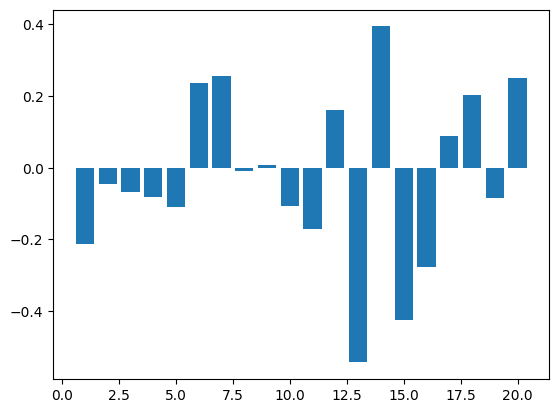

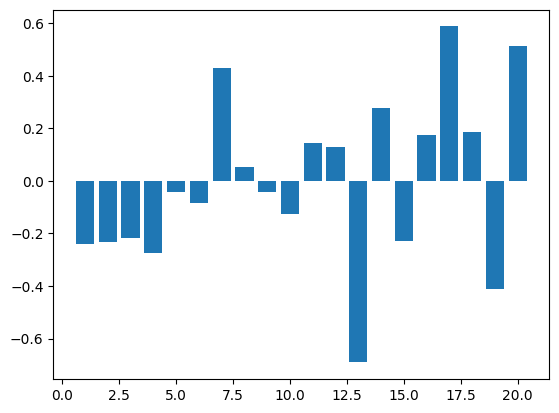

In [168]:
#sigmoid = nn.Sigmoid()
x_axis = np.linspace(1,20,20)
model.to('cpu')
prot = random.choice(val_data)
prediction = model.forward(prot[0].to('cpu'))


#plt.hist(prediction.detach().numpy(),10)
#plt.yscale('log')
#plt.show()

plt.bar(x_axis, prediction.detach().numpy())
plt.show()

#plt.hist(prot[1].detach().numpy(),10)
#plt.yscale('log')
#plt.show()

plt.bar(x_axis, prot[1].detach().numpy())
plt.show()

In [144]:
func_real = np.zeros(len(CC_Codes))
for prot in prot_list:
    func_real += prot[1].numpy()
    
weight = np.zeros(len(CC_Codes))
for i in range(len(CC_Codes)):
    positive = func_real[i]
    negative = len(prot_list) - func_real[i]
    if positive < 1:
        weight[i] = 0.0
    else:
        weight[i] = 1.0 #(negative/positive) #10.0*tanh((negative/positive)/15.0)  #* (15.0/len(CC_Codes))

func = np.zeros(len(CC_Codes))
model_gcn.to('cpu')
sigmoid = nn.Sigmoid()
for prot in prot_list:
    prediction = sigmoid(model_gcn.forward(prot[0].to('cpu')))
    #prediction = model_gcn.forward(prot[0].to('cpu'))
    for i in range(len(prediction)):
        if weight[i] == 0:
            prediction[i] = 0.0      
    func += prediction.to('cpu').detach().numpy()

NameError: name 'prot_list' is not defined

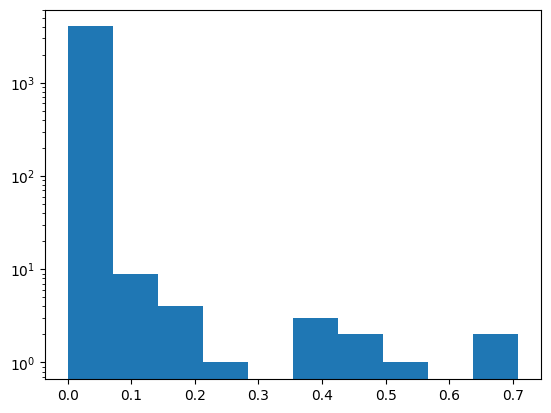

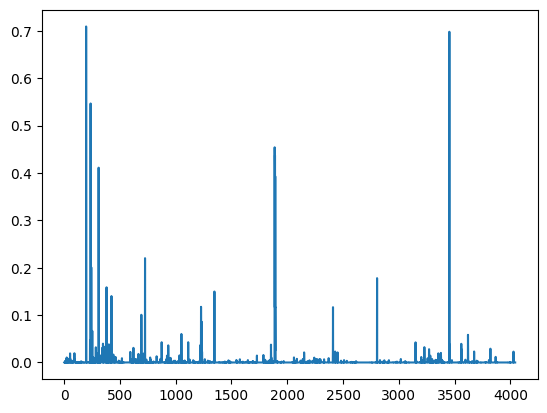

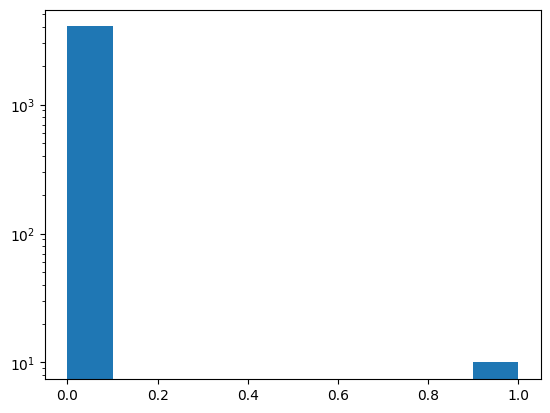

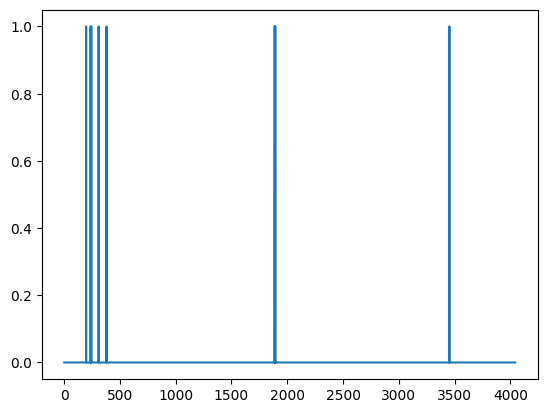

In [197]:
model_gcn.to('cpu')
prot = random.choice(prot_list)
prediction = sigmoid(model_gcn.forward(prot[0].to('cpu')))


plt.hist(prediction.detach().numpy(),10)
plt.yscale('log')
plt.show()

plt.plot(x_axis, prediction.detach().numpy())
plt.show()

plt.hist(prot[1].detach().numpy(),10)
plt.yscale('log')
plt.show()

plt.plot(x_axis, prot[1].detach().numpy())
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4043,) and arg 1 with shape (2,).

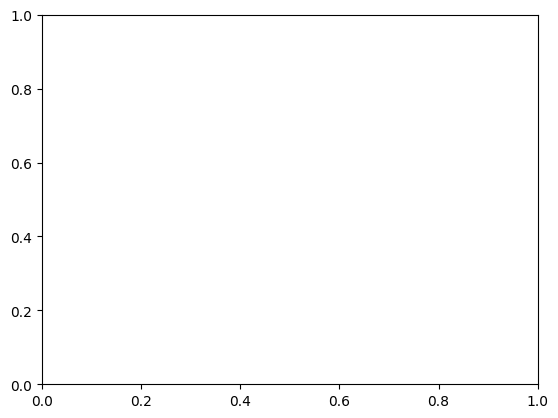

In [159]:
x_axis = np.linspace(1,len(CC_Codes),len(CC_Codes))
plt.bar(x_axis,func)
plt.axis([0,len(CC_Codes),0,60000])

In [126]:
func_test = np.zeros(len(CC_Codes))
model_gcn.to('cpu')
sigmoid = nn.Sigmoid()
for prot in val_data:
    prediction = sigmoid(model_gcn.forward(prot[0].to('cpu')))
    #prediction = model_gcn.forward(prot[0].to('cpu'))
    for i in range(len(prediction)):
        if weight[i] == 0:
            prediction[i] = 0.0      
    func_test += prediction.to('cpu').detach().numpy()

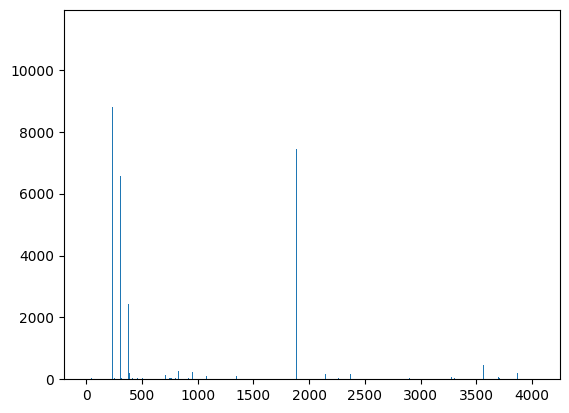

In [176]:
plt.bar(x_axis,func_test)
#plt.axis([0,len(CC_Codes),0,1000])
plt.show()

In [127]:
func_real_test = np.zeros(len(CC_Codes))
for prot in val_data:
    func_real_test += prot[1].numpy()

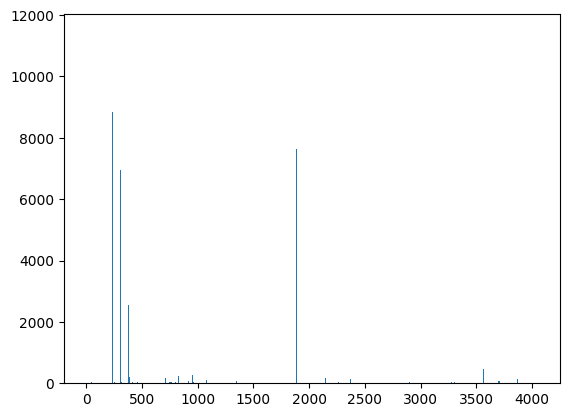

In [177]:
plt.bar(x_axis,func_real_test)
#plt.axis([0,len(CC_Codes),0,1000])
plt.show()

In [128]:
func_train = np.zeros(len(CC_Codes))
model_gcn.to('cpu')
sigmoid = nn.Sigmoid()
for prot in train_data:
    prediction = sigmoid(model_gcn.forward(prot[0].to('cpu')))
    #prediction = model_gcn.forward(prot[0].to('cpu'))
    for i in range(len(prediction)):
        if weight[i] == 0:
            prediction[i] = 0.0      
    func_train += prediction.to('cpu').detach().numpy()

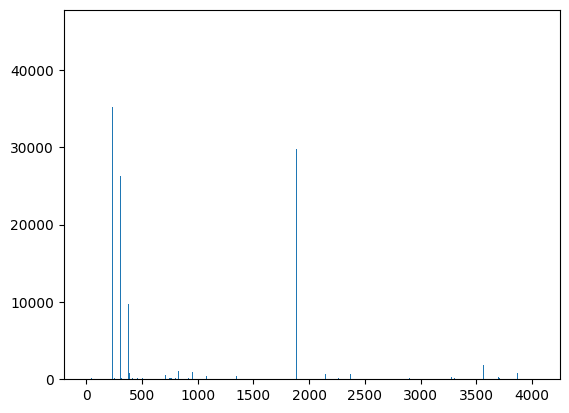

In [178]:
plt.bar(x_axis,func_train)
#plt.axis([0,len(CC_Codes),0,1000])
plt.show()

In [129]:
func_real_train = np.zeros(len(CC_Codes))
for prot in train_data:
    func_real_train += prot[1].numpy()

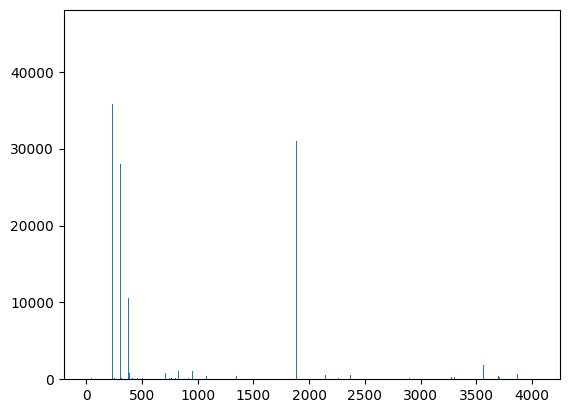

In [179]:
plt.bar(x_axis,func_real_train)
#plt.axis([0,len(CC_Codes),0,1000])
plt.show()

In [58]:
func_real = np.zeros(len(CC_Codes))
for prot in prot_list:
    func_real += prot[1].numpy()

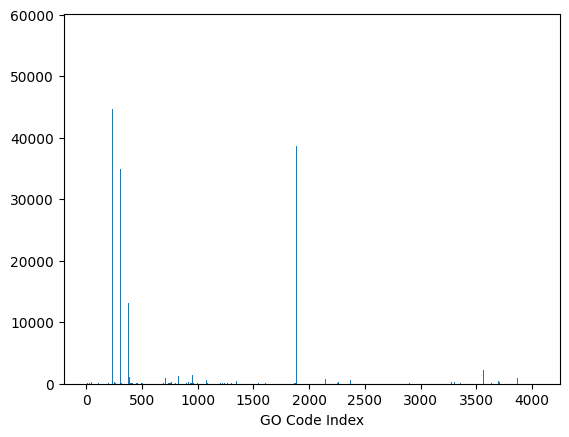

In [175]:
x_axis = np.linspace(1,len(CC_Codes),len(CC_Codes))
plt.bar(x_axis,func_real)
#plt.yscale('log')
#plt.xlim([0,len(CC_Codes)])
plt.xlabel('GO Code Index')
#plt.ylabel('Occupation')
plt.show()

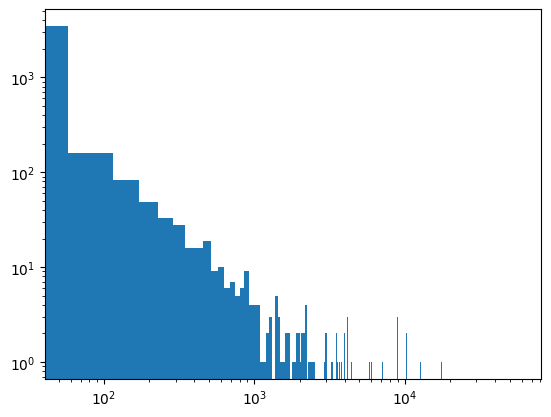

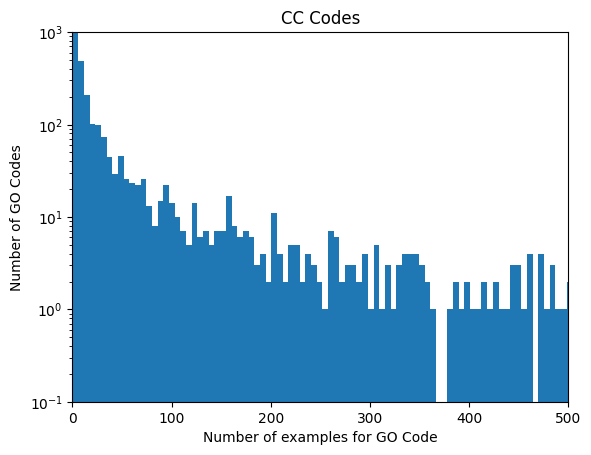

In [158]:
plt.hist(func_real,1000)
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.hist(func_real,10000)
plt.yscale('log')
plt.ylim([0.1,1000])
plt.xlim([0,500])
plt.title('CC Codes')
plt.xlabel('Number of examples for GO Code')
plt.ylabel('Number of GO Codes')
plt.show()

In [63]:
torch.save(model_gcn, 'GAT_CC_codes_train_09272023.pkl')

In [102]:
from sklearn.metrics import f1_score
def calc_f1_score(pred,truth,weight,thresh):
    filtered_pred = [pred[i] for i in range(len(weight)) if weight[i] > 0.5]
    filtered_truth = [truth[i] for i in range(len(weight)) if weight[i] > 0.5]
    predict = []
    for i in range(len(filtered_pred)):
        if (filtered_pred[i] > thresh):
            predict.append(1)
        else:
            predict.append(0)
    f1 = f1_score(filtered_truth,predict,zero_division = 0.0)
    return f1, predict

In [103]:
model_gcn.to(DEVICE)
weights = weights.to('cpu')
func = np.zeros(len(prot_list[1]))
thresh_vec = np.linspace(0.1,0.95,20)
f1 = []
for prot in prot_list:
    prediction = sigmoid(model_gcn.forward(prot[0].to(DEVICE))).to('cpu').detach().numpy()
    prot[0].to('cpu')
    f_vec = []
    for thresh in thresh_vec:
        f,pred = calc_f1_score(prediction,prot[1].numpy(),weights,thresh)
        f_vec.append(f)
    f1.append(f_vec)

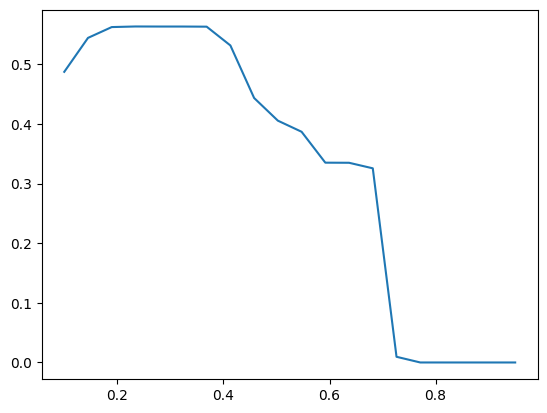

In [120]:
avg_f1 = np.zeros(len(thresh_vec))
count = 0
for i in range(len(f1)):
    total = 0
    for j in prot_list[i][1]:
        total+= j
    if total >= 1.0:
        avg_f1 += f1[i]
        count += 1
avg_f1 /= count

plt.plot(thresh_vec,avg_f1)
plt.show()

In [130]:
model_gcn.to(DEVICE)
weights = weights.to('cpu')
func = np.zeros(len(prot_list[1]))
thresh_vec = np.linspace(0.1,0.95,20)
f1_train = []
for prot in train_data:
    prediction = sigmoid(model_gcn.forward(prot[0].to(DEVICE))).to('cpu').detach().numpy()
    prot[0].to('cpu')
    f_vec = []
    for thresh in thresh_vec:
        f,pred = calc_f1_score(prediction,prot[1].numpy(),weights,thresh)
        f_vec.append(f)
    f1_train.append(f_vec)

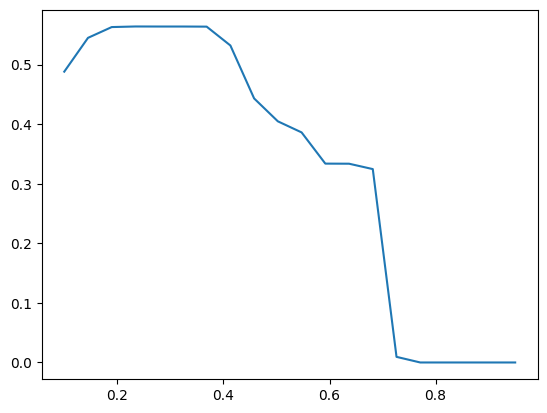

In [131]:
avg_f1_train = np.zeros(len(thresh_vec))
count = 0
for i in range(len(f1_train)):
    total = 0
    for j in train_data[i][1]:
        total+= j
    if total >= 1.0:
        avg_f1_train += f1_train[i]
        count += 1
avg_f1_train /= count

plt.plot(thresh_vec,avg_f1_train)
plt.show()

In [132]:
model_gcn.to(DEVICE)
weights = weights.to('cpu')
func = np.zeros(len(prot_list[1]))
thresh_vec = np.linspace(0.1,0.95,20)
f1_test = []
for prot in val_data:
    prediction = sigmoid(model_gcn.forward(prot[0].to(DEVICE))).to('cpu').detach().numpy()
    prot[0].to('cpu')
    f_vec = []
    for thresh in thresh_vec:
        f,pred = calc_f1_score(prediction,prot[1].numpy(),weights,thresh)
        f_vec.append(f)
    f1_test.append(f_vec)

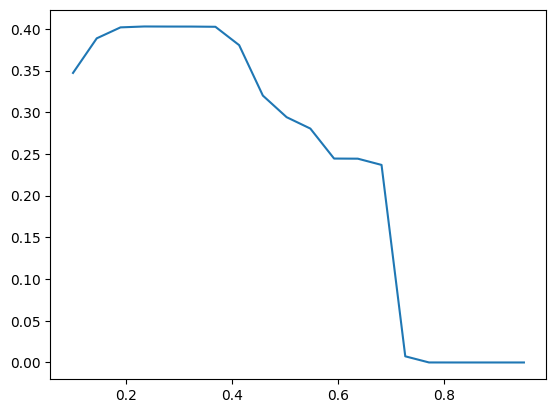

In [133]:
avg_f1_test = np.zeros(len(thresh_vec))
count = 0
for i in range(len(f1_test)):
    total = 0
    for j in test_data[i][1]:
        total+= j
    if total >= 1.0:
        avg_f1_test += f1_test[i]
        count += 1
avg_f1_test /= count

plt.plot(thresh_vec,avg_f1_test)
plt.show()

In [138]:
print(avg_f1_test)

[3.47091574e-01 3.88573732e-01 4.01702548e-01 4.02781483e-01
 4.02684934e-01 4.02664836e-01 4.02409063e-01 3.80416375e-01
 3.19924007e-01 2.94062110e-01 2.80399802e-01 2.44453359e-01
 2.44308305e-01 2.36828071e-01 7.38908760e-03 2.67422828e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


In [115]:
print(UniIDs[5])

Q9GPR7


In [118]:
total = 0
for i in prot_list[5][1]:
    total += i
print(total)

tensor(0., dtype=torch.float64)


In [117]:
print(prot_list[5][1])

tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)


In [119]:
count = 0
for i in range(len(prot_list)):
    total = 0
    for j in prot_list[i][1]:
        total+= j
    if total < 1.0:
        count += 1
print(count)

22502
